In [1]:
!pip install langchain openai langchain_openai datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 632.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00


In [2]:
from google.colab import userdata

In [3]:
from datasets import load_dataset

ds = load_dataset("fawern/visual-question-answering-coco")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/344 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/217 [00:00<?, ? examples/s]

In [73]:
import requests
from PIL import Image
from io import BytesIO

def display_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    img.show()

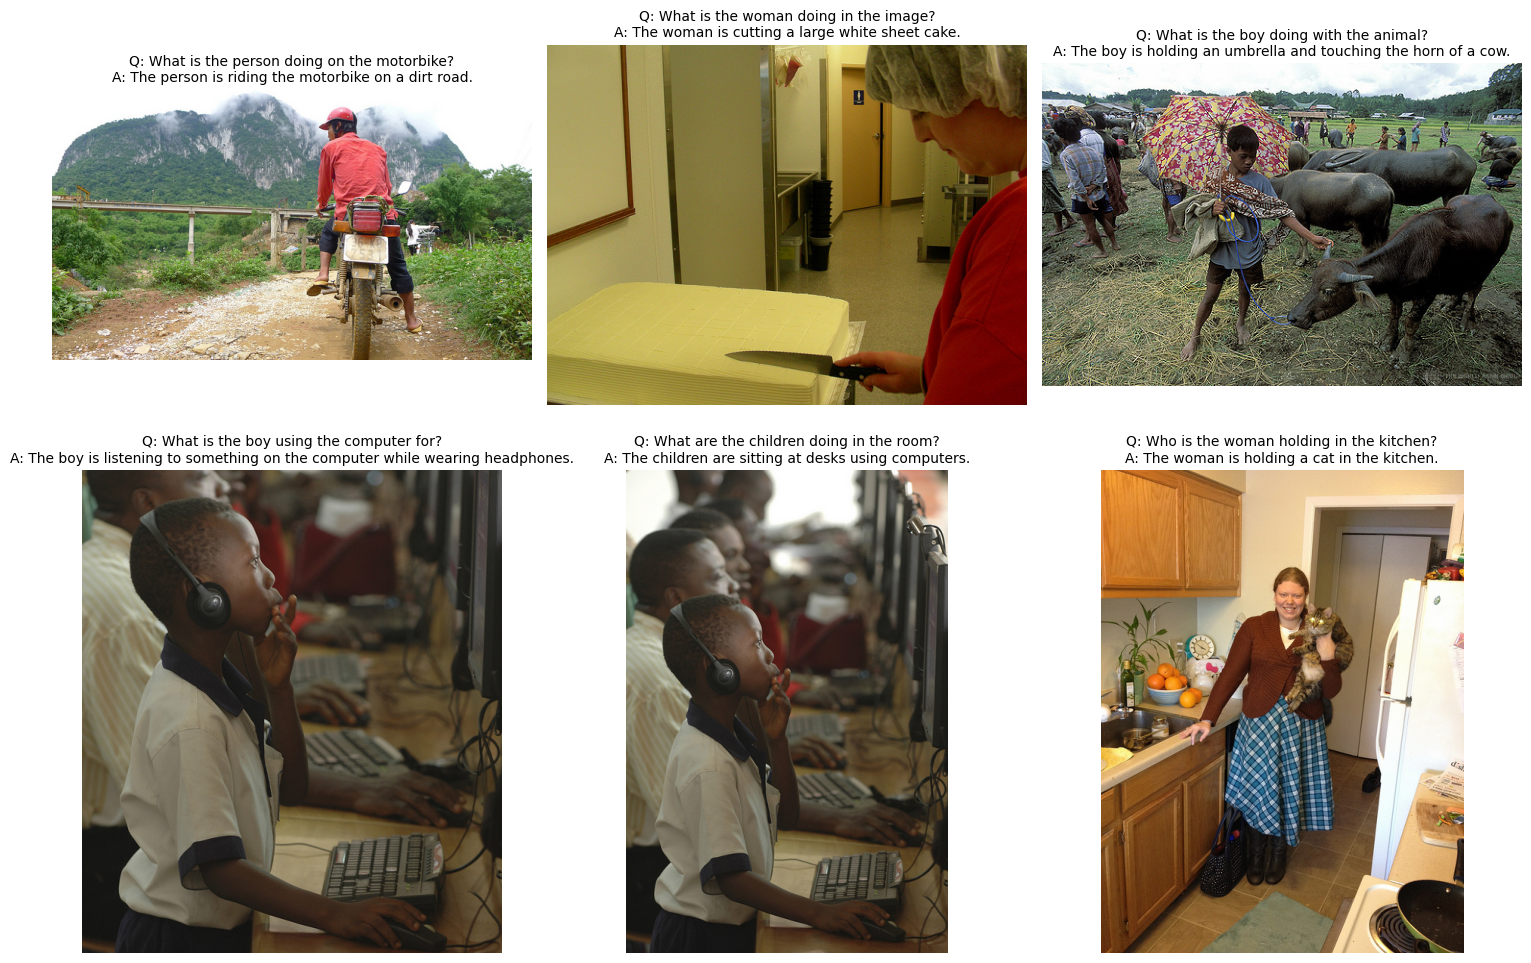

In [74]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_images_from_dataset(dataset, num_images=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(num_images):
        example = dataset[i]
        image_url = example['image_url']
        question = example['question']
        answer = example['answer']

        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))

        axes[i].imshow(img)
        axes[i].set_title(f"Q: {question}\nA: {answer}", fontsize=10)
        axes[i].axis('off')  # Remove os eixos para melhor visualização

    plt.tight_layout()
    plt.show()

from datasets import load_dataset
ds = load_dataset("fawern/visual-question-answering-coco")

display_images_from_dataset(ds['train'])

In [75]:
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [76]:
from langchain_openai import OpenAIEmbeddings
from langchain_openai import OpenAI

In [77]:
def generate_embedding_with_ada(text: str) -> list:
    embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002")
    embedding = embeddings_model.embed_query(text)
    return embedding

In [78]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

def qualitative_evaluation_with_model(model, answer: str, question: str, reference_answer: str, aspect: str) -> str:
    prompt_template = PromptTemplate(
        input_variables=["answer", "question", "reference_answer"],
        template=(
            f"Evaluate the {aspect} of the answer '{{answer}}' to the question '{{question}}', "
            f"compared to the reference answer '{{reference_answer}}'."
        )
    )

    llm_chain = LLMChain(llm=model, prompt=prompt_template)

    evaluation = llm_chain.run(answer=answer, question=question, reference_answer=reference_answer)
    return evaluation

In [79]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.distance import cosine
from typing import List, Dict

In [80]:
from datasets import load_dataset, DatasetDict
import pandas as pd
import os

class DatasetLoader:
    def __init__(self, data_path):
        self.data_path = data_path

    def load_data(self):
        if isinstance(self.data_path, DatasetDict):
            return self.data_path
        elif isinstance(self.data_path, str) and os.path.isfile(self.data_path):
            data = pd.read_csv(self.data_path)
        elif isinstance(self.data_path, str):
            data = load_dataset(self.data_path)
        else:
            raise ValueError("O parâmetro data_path deve ser um caminho de arquivo, nome de dataset da Hugging Face, ou um DatasetDict.")

        return data

In [81]:
class DataPreprocessor:
    def preprocess(self, data):
        data['question'] = data['question'].str.lower().str.strip()
        data['answer'] = data['answer'].str.lower().str.strip()
        return data

In [89]:
from langchain_openai import ChatOpenAI
from sklearn.metrics import accuracy_score, f1_score
from datasets import DatasetDict
from typing import List, Dict

class ModelRunner:
    def __init__(self, dataset, model, limit=5):
        self.dataset = dataset[:limit] if isinstance(dataset, list) else list(dataset)[:limit]
        self.model = model
        self.reference_answers = [example['answer'] for example in self.dataset]
        self.model_answers = []

    def get_answer(self, index):
        example = self.dataset[index]
        image_url = example.get('image_url', 'URL not available')
        question = example.get('question', 'Question not available')
        answer = example.get('answer', 'Answer not available')
        return image_url, question, answer

    def evaluate_answer(self, index) -> Dict[str, str]:
        image_url, question, answer = self.get_answer(index)

        relevance_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant evaluating relevance."),
            ("human", "Evaluate the relevance of the answer '{answer}' to the question '{question}'.")
        ])
        coherence_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant evaluating coherence."),
            ("human", "Evaluate the coherence of the answer '{answer}' to the question '{question}'.")
        ])
        clarity_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant evaluating clarity."),
            ("human", "Evaluate the clarity of the answer '{answer}' to the question '{question}'.")
        ])

        relevance_chain = LLMChain(llm=self.model, prompt=relevance_prompt)
        coherence_chain = LLMChain(llm=self.model, prompt=coherence_prompt)
        clarity_chain = LLMChain(llm=self.model, prompt=clarity_prompt)

        relevance_evaluation = relevance_chain.invoke({"answer": answer, "question": question})["text"]
        coherence_evaluation = coherence_chain.invoke({"answer": answer, "question": question})["text"]
        clarity_evaluation = clarity_chain.invoke({"answer": answer, "question": question})["text"]

        model_answer = relevance_evaluation
        self.model_answers.append(model_answer)

        return {
            "relevance": relevance_evaluation,
            "coherence": coherence_evaluation,
            "clarity": clarity_evaluation,
            "image_url": image_url
        }

    def accuracy(self):
        return accuracy_score(self.reference_answers, self.model_answers)

    def f1_score(self):
        return f1_score(self.reference_answers, self.model_answers, average='weighted')

    def vqa_metrics(self):
        return {
            "accuracy": self.accuracy(),
            "f1_score": self.f1_score()
        }

In [83]:
class MetricsEvaluator:
    def __init__(self, reference_answers: List[str], model_answers: List[str], questions: List[str]):
        self.reference_answers = reference_answers
        self.model_answers = model_answers
        self.questions = questions

    def accuracy(self):
        return accuracy_score(self.reference_answers, self.model_answers)

    def f1_score(self):
        return f1_score(self.reference_answers, self.model_answers, average='weighted')

    def semantic_relevance(self):
        similarities = []
        for ref, model_ans in zip(self.reference_answers, self.model_answers):
            ref_embedding = generate_embedding_with_ada(ref)
            model_embedding = generate_embedding_with_ada(model_ans)
            similarity = 1 - cosine(ref_embedding, model_embedding)
            similarities.append(similarity)
        return np.mean(similarities)

    def qualitative_evaluation(self):
        evaluations = []
        for question, ref, model_ans in zip(self.questions, self.reference_answers, self.model_answers):
            eval_text = ModelRunner.evaluate_answer(model_ans, question, ref)
            evaluations.append(eval_text)
        return evaluations

    def evaluate(self):
        metrics = {
            "accuracy": self.accuracy(),
            "f1_score": self.f1_score(),
            "semantic_relevance": self.semantic_relevance(),
            "qualitative_evaluation": self.qualitative_evaluation()
        }
        return metrics

In [98]:
class ResultsReporter:
    def __init__(self, evaluations, metrics):
        self.evaluations = evaluations
        self.metrics = metrics

    def report_to_csv(self, filename="vqa_report.csv"):
        eval_df = pd.DataFrame(self.evaluations)
        metrics_df = pd.DataFrame([self.metrics])
        full_df = pd.concat([eval_df, metrics_df], ignore_index=True)
        full_df.to_csv(filename, index=False)
        print(f"Report saved to {filename}")

In [99]:
def main(dataset, model):
    loader = DatasetLoader(dataset)
    data = loader.load_data()
    if isinstance(data, DatasetDict) and 'train' in data:
        data = list(data['train'])[:5]

    model_runner = ModelRunner(data, model, limit=5)

    evaluations = [model_runner.evaluate_answer(i) for i in range(5)]
    vqa_metrics = model_runner.vqa_metrics()

    reporter = ResultsReporter(evaluations, vqa_metrics)
    reporter.report_to_csv("vqa_report.csv")

    df = pd.read_csv("vqa_report.csv")
    print("\nReport:")
    print(df)

In [100]:
from langchain_openai import ChatOpenAI
from datasets import load_dataset

ds = load_dataset("fawern/visual-question-answering-coco")
model = ChatOpenAI(model="gpt-4o-mini", temperature=0, max_tokens=200)

main(ds, model)

Report saved to vqa_report.csv

Report:
                                           relevance  \
0  The answer 'The person is riding the motorbike...   
1  The answer 'The woman is cutting a large white...   
2  The answer 'The boy is holding an umbrella and...   
3  The answer 'The boy is listening to something ...   
4  The answer 'The children are sitting at desks ...   
5                                                NaN   

                                           coherence  \
0  The answer "The person is riding the motorbike...   
1  The answer 'The woman is cutting a large white...   
2  The answer "The boy is holding an umbrella and...   
3  The answer "The boy is listening to something ...   
4  The answer "The children are sitting at desks ...   
5                                                NaN   

                                             clarity  \
0  The answer "The person is riding the motorbike...   
1  The answer "The woman is cutting a large white...   
2  The